## 1. Spatial feature integration of mouse olfactory bulb datasets

First, we present an example of using STAIR for spatial feature integration and region delineation. Showcasing spatial feature integration separately is necessary because the data required for analysis may not necessarily share a unified physical space.

## Import packsges¶

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

from STAIR.emb_alignment import Emb_Align
from STAIR.utils import *

## load data

In [2]:
# load data

adata_stere = sc.read('./data/MoB_Stereo-seq.h5ad')
adata_slide = sc.read('./data/MoB_Slide-seqV2.h5ad')

adata = ad.concat({'Stereo-seq':adata_stere, 'Slide-seqV2':adata_slide}, label='batch')
adata

AnnData object with n_obs × n_vars = 37757 × 12572
    obs: 'n_genes', 'batch'
    obsm: 'spatial'

In [3]:
result_path = 'OB'
keys_use = ['Stereo-seq', 'Slide-seqV2']

## Preprocess

In [4]:
# construct the model
emb_align = Emb_Align(adata, 
                      batch_key = 'batch',
                      hvg = 3000, 
                      likelihood = 'zinb',
                      result_path = result_path, 
                      device = 'cuda:0')
# preprocessing
emb_align.prepare()
emb_align.preprocess()
emb_align.latent()

100%|████████████████████████████████████████████████████████████████████████| 100/100 [09:28<00:00,  5.68s/it]


## Spatial embedding alignment

In [5]:
# construct the heterogeneous graph
emb_align.prepare_hgat(slice_key = 'batch', slice_order = keys_use, n_neigh_hom = 10, c_neigh_het = 0.9)
# train and predict
emb_align.train_hgat(gamma = 0.8)
adata, _ = emb_align.predict_hgat()

# clustering of spatial embedding
adata = cluster_func(adata, clustering='mclust', use_rep='STAIR', cluster_num=9, key_add='STAIR')

100%|████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 53.92it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Visualization

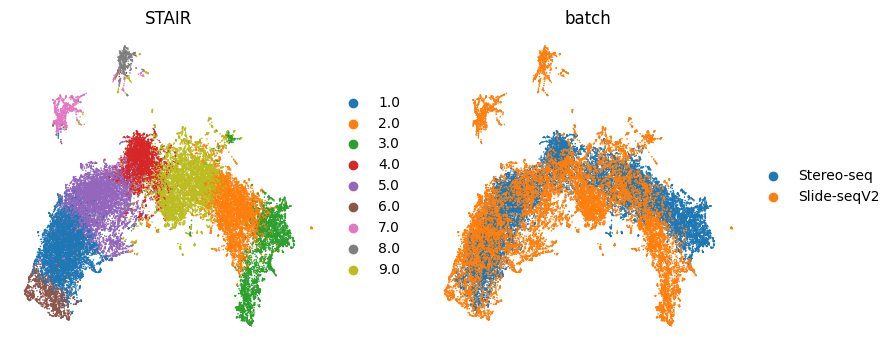

In [6]:
# UMAP visualization

sc.pp.neighbors(adata, use_rep='STAIR')
sc.tl.umap(adata, min_dist=0.2)

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata, color=['STAIR', 'batch'],
                    frameon=False, show=True, ncols=2, s=5)

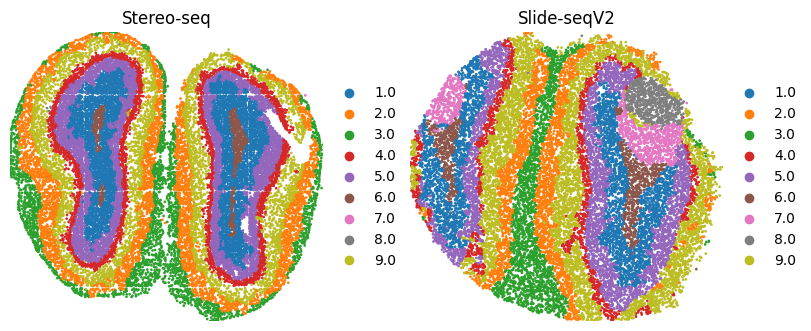

In [7]:
# Spatial visualization

n_row = 1
n_col = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(8,3.2),constrained_layout=True)

index = 0
for i in range(len(keys_use)):
    # axs[i,j].get_xaxis().set_visible(False)
    # axs[i,j].get_yaxis().set_visible(False)
    axs[i].axis('off')
    if index < len(keys_use):
        key = keys_use[index]
        adata_tmp = adata[adata.obs['batch']==key].copy()
        sc.pl.embedding(adata_tmp, basis='spatial', color='STAIR', title=key, frameon=False, s=15, show=False, ax=axs[i])
        axs[i].set_xlim([adata_tmp.obsm['spatial'].min(0)[0], adata_tmp.obsm['spatial'].max(0)[0]])
        axs[i].set_ylim([adata_tmp.obsm['spatial'].min(0)[1], adata_tmp.obsm['spatial'].max(0)[1]])
        i += 1
    index += 1

plt.show()
plt.close()